In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from tpot import TPOTClassifier


npf = pd.read_csv('data/npf_train.csv')

npf.drop("partlybad", axis=1, inplace=True)
npf.set_index("date", inplace=True)
npf["class4"] = npf["class4"].astype("category")
npf.drop("id", axis=1, inplace=True)
class2 = np.array(["event"]*npf.shape[0],dtype="object")
class2[npf["class4"]=="nonevent"] = "nonevent"
npf.insert(0, 'class2', class2)
npf["class2"] = npf["class2"].astype("category")
npf.insert(2, "year", pd.DatetimeIndex(npf.index).year)
npf.insert(2, "month", pd.DatetimeIndex(npf.index).month)
npf.insert(2, "event", pd.get_dummies(npf["class2"])["event"])

monthmap = {1:1, 2:3, 3:10, 4:12, 5:11, 6:9, 7:4, 8:7, 9:8, 10:5, 11:2, 12:6} # months ordered descending by event rate
npf["month"] = npf.month.map(monthmap)

classmap = {'nonevent':0, 'II':1, 'Ib':2, 'Ia':3}
npf.insert(2, "y4", npf.class4.map(classmap))

In [3]:
npf

,class2,class4,y4,event,month,year,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,...,T672.mean,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,nonevent,nonevent,0,0,1,2000,384.462000,2.284996,384.164462,2.135062,...,-13.016471,0.525698,-12.422972,0.376324,1.635563,0.856948,0.026438,0.014617,0.003374,0.000733
2000-01-20,nonevent,nonevent,0,0,1,2000,374.884615,0.415185,374.703333,0.385179,...,-8.997430,0.373927,-8.351043,0.575679,1.441109,0.741088,0.022649,0.012479,0.001501,0.000572
2000-01-23,nonevent,nonevent,0,0,1,2000,373.496585,0.189497,373.382593,0.172958,...,-10.224472,0.965988,-9.651155,1.238891,2.677545,1.261612,0.044759,0.023748,0.000764,0.000048
2000-02-17,nonevent,nonevent,0,0,3,2000,378.600367,1.934180,378.464862,1.946536,...,-1.535183,0.122651,-0.829524,0.134191,2.261805,1.345651,0.030893,0.021903,0.002038,0.000751
2000-03-25,event,Ib,2,1,10,2000,373.128684,1.096617,372.980000,1.047750,...,-2.095641,1.695622,-1.095864,2.090111,12.906779,7.022300,0.333523,0.239981,0.000662,0.000210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-08-14,nonevent,nonevent,0,0,7,2011,377.541538,6.391551,377.802756,6.187754,...,16.470062,2.142789,17.077060,2.779125,16.129744,12.203500,0.786032,0.696306,0.002360,0.000253
2011-08-16,nonevent,nonevent,0,0,7,2011,381.016623,4.411571,381.030844,4.062115,...,16.319361,1.089563,17.268471,1.308728,8.688739,8.320799,0.464422,0.496816,0.002423,0.000425
2011-08-18,nonevent,nonevent,0,0,7,2011,386.687895,12.065627,386.284079,11.751004,...,13.315270,0.511146,13.781909,0.838839,7.375727,5.115708,0.366155,0.316015,0.001993,0.000391


In [4]:
y_bin = npf.event.values
y_multi = npf.y4.values
X_unscaled = npf.values[:,4:]
scaler = MinMaxScaler()
scaler.fit(X_unscaled)
X = scaler.transform(X_unscaled)
features = list(npf.columns)[4:]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(366, 102)
(92, 102)


Feature Selection

https://towardsdatascience.com/feature-selection-using-python-for-classification-problem-b5f00a1c7028 

PCA, look at components that explain most of the variance in the model
Univariate feature selection, compares each feature to the target and outputs the statistic. Then we pick the best ones. Can do this with chi-squared, f-test, Mutual Information (dependency)
Can use SelectFromModel function which considers all features at once.
Can use 



In [6]:
#for univariate feature selection, using both chi_2 and f_statistic as our scores
chi_2_featureSelections = []
f_stat_featureSelections = []

numFeatures = [10,20,50,70,90,102]

for num in numFeatures:
    chi_2_featureSelections.append(SelectKBest(chi2, k=num).fit_transform(X_train, y_train))
    f_stat_featureSelections.append(SelectKBest(f_classif, k=num).fit_transform(X_train, y_train))

If using RandomForest Classifier we can do feature selection with bootstrap sampling and assigned feature_importance scores. Then do recursive feature selection.

In [7]:
n_estimators = [500,50,10,100]
max_depth = [100,10,5,None]
min_sample_split = [16,8,4,2]
#i = 3 are default values
for i in range(4):
    rf = RandomForestClassifier(random_state=0,n_estimators=n_estimators[i],max_depth=max_depth[i],min_samples_split=min_sample_split[i])
    rf.fit(X_train,y_train)
    f_i = list(zip(features,rf.feature_importances_))
    f_i.sort(key = lambda x : x[1])
    f_i = [x[0] for x in f_i]
    print(f_i[0:15],"\n")

['O384.std', 'month', 'H2O336.std', 'NO504.mean', 'H2O168.std', 'H2O42.std', 'NO672.mean', 'O3168.std', 'O3504.std', 'SWS.std', 'H2O504.std', 'NO42.mean', 'O3504.mean', 'SO2168.std', 'O342.std'] 

['T168.std', 'NOx504.mean', 'H2O168.std', 'RPAR.std', 'month', 'T84.mean', 'O3168.std', 'O3672.std', 'NO42.mean', 'H2O42.std', 'O342.std', 'T672.std', 'T504.std', 'CO2168.std', 'NOx504.std'] 

['CO242.std', 'Glob.std', 'H2O84.std', 'NO42.std', 'NO672.mean', 'NOx168.std', 'NOx672.mean', 'NOx84.std', 'PTG.mean', 'RPAR.mean', 'RPAR.std', 'T42.std', 'T504.std', 'T672.std', 'PAR.std'] 

['month', 'O3504.std', 'T504.std', 'NO336.mean', 'T168.std', 'O342.std', 'PTG.mean', 'H2O336.std', 'H2O42.std', 'O3168.std', 'NO504.mean', 'RPAR.std', 'CO2336.mean', 'NOx504.std', 'H2O84.std'] 



In [51]:
#note that this block took 2h23min to complete
results1 = []
for n_est in n_estimators:
    for m_dep in max_depth:
        for min_sam in min_sample_split:
            rf = RandomForestClassifier(random_state=0,n_estimators=n_est,max_depth=m_dep,min_samples_split=min_sam)
            rf.fit(X_train,y_train)
            rfe = RFECV(rf,cv=5,scoring="accuracy")
            rfe.fit(X_train,y_train)
            selected_features = np.array(features)[rfe.get_support()]
            #print(selected_features)
            y_pred_rfecv = rfe.predict(X_test)
            #print(f"n_estimators = {n_est}, max_depth = {m_dep}, min_samples_split = {min_sam}\n")
            #print("\nAccuracy:",accuracy_score(y_test, y_pred_rfecv))
            tup = (accuracy_score(y_test, y_pred_rfecv),n_est,m_dep,min_sam)
            results1.append(tup)
results1.sort(key = lambda x: x[0],reverse = True)
print(results1)

[(0.6413043478260869, 50, 100, 8), (0.6413043478260869, 50, None, 8), (0.6195652173913043, 10, 100, 4), (0.6195652173913043, 10, 100, 2), (0.6195652173913043, 10, None, 4), (0.6195652173913043, 10, None, 2), (0.6086956521739131, 10, 10, 8), (0.6086956521739131, 10, 10, 4), (0.6086956521739131, 100, 10, 8), (0.5978260869565217, 500, 100, 4), (0.5978260869565217, 500, 10, 8), (0.5978260869565217, 500, 10, 4), (0.5978260869565217, 500, 10, 2), (0.5978260869565217, 500, None, 4), (0.5978260869565217, 50, 100, 2), (0.5978260869565217, 50, 10, 16), (0.5978260869565217, 50, 10, 8), (0.5978260869565217, 50, 10, 4), (0.5978260869565217, 50, 10, 2), (0.5978260869565217, 50, None, 2), (0.5978260869565217, 100, 100, 8), (0.5978260869565217, 100, 100, 4), (0.5978260869565217, 100, 100, 2), (0.5978260869565217, 100, 10, 4), (0.5978260869565217, 100, None, 8), (0.5978260869565217, 100, None, 4), (0.5978260869565217, 100, None, 2), (0.5869565217391305, 500, 100, 16), (0.5869565217391305, 500, 100, 8),

Now using PCA for feature selection.

In [8]:
NumComponents = [10,20,50,70,90,102]
results = []
for n_est in n_estimators:
    for m_dep in max_depth:
        for min_sam in min_sample_split:
            for num in NumComponents:
                pca = PCA(n_components=num)
                X_train1 = pca.fit_transform(X_train)
                X_test1 = pca.transform(X_test)
                rf = RandomForestClassifier(random_state=0,n_estimators=n_est,max_depth=m_dep,min_samples_split=min_sam)
                rf.fit(X_train1,y_train)
                y_pred_pca = rf.predict(X_test1)
                tup = (accuracy_score(y_test, y_pred_pca),num,n_est,m_dep,min_sam)
                results.append(tup)
                #print(f'Accuracy with {num} components, n_estimators = {n_est}, max_depth = {m_dep}, min_samples_split = {min_sam}: {accuracy_score(y_test, y_pred_pca)}\n')

results.sort(key = lambda x: x[0],reverse = True)
print(results)

[(0.717391304347826, 10, 10, 10, 2), (0.6847826086956522, 10, 500, 10, 2), (0.6847826086956522, 10, 10, 10, 16), (0.6739130434782609, 10, 500, 100, 8), (0.6739130434782609, 10, 500, 100, 4), (0.6739130434782609, 10, 500, 10, 4), (0.6739130434782609, 10, 500, None, 8), (0.6739130434782609, 10, 500, None, 4), (0.6739130434782609, 10, 10, 100, 4), (0.6739130434782609, 10, 10, None, 4), (0.6739130434782609, 10, 100, 100, 16), (0.6739130434782609, 10, 100, 10, 4), (0.6739130434782609, 10, 100, 5, 4), (0.6739130434782609, 10, 100, None, 16), (0.6630434782608695, 10, 500, 100, 16), (0.6630434782608695, 10, 500, 100, 2), (0.6630434782608695, 10, 500, 10, 16), (0.6630434782608695, 10, 500, 10, 8), (0.6630434782608695, 10, 500, None, 16), (0.6630434782608695, 10, 500, None, 2), (0.6630434782608695, 10, 50, 10, 16), (0.6630434782608695, 10, 50, 10, 2), (0.6630434782608695, 10, 10, 10, 8), (0.6630434782608695, 10, 100, 10, 16), (0.6630434782608695, 10, 100, 5, 2), (0.6521739130434783, 10, 500, 5, 

In [15]:
[item for item in results if (item[2] == 500) and (item[3] == 10) and (item[4] == 2)]

[(0.6847826086956522, 10, 500, 10, 2),
 (0.6195652173913043, 20, 500, 10, 2),
 (0.5869565217391305, 50, 500, 10, 2),
 (0.5869565217391305, 70, 500, 10, 2),
 (0.5434782608695652, 90, 500, 10, 2),
 (0.532608695652174, 102, 500, 10, 2)]

In [149]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, C=0.01))),
  ('classification', RandomForestClassifier())
])
model = clf.fit(X_train, y_train)

In [150]:
y_pred = model.predict(X_test)
y_pred

array([1, 0, 3, 1, 1, 1, 1, 2, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 1, 1, 0, 2,
       1, 0, 2, 0, 2, 0, 1, 0, 0, 1, 2, 2, 0, 1, 0, 1, 0, 2, 1, 1, 2, 0,
       1, 0, 3, 1, 3, 1, 2, 2, 2, 0, 2, 1, 0, 1, 1, 2, 1, 0, 0, 0, 0, 0,
       2, 2, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0], dtype=int64)

In [151]:
def print_classification_metrics(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=["nonevent", "II", "Ib", "Ia"])
    _ = cmd.plot()

              precision    recall  f1-score   support

           0       0.59      0.72      0.65        36
           1       0.43      0.43      0.43        28
           2       0.41      0.29      0.34        24
           3       0.00      0.00      0.00         4

    accuracy                           0.49        92
   macro avg       0.36      0.36      0.36        92
weighted avg       0.47      0.49      0.47        92



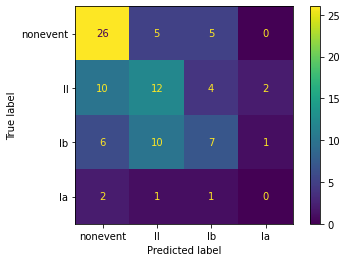

In [152]:
print_classification_metrics(y_test, y_pred)

In [153]:
tpot_enabled = False
if cell_enabled:
    tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
    tpot.fit(X_train, y_train)
    print(tpot.score(X_test, y_test))
    tpot.export('tpot_npf_pipeline.py')
    y_pred = tpot.predict(X_test)


Generation 1 - Current best internal CV score: 0.6913365420214734

Generation 2 - Current best internal CV score: 0.6913365420214734

Generation 3 - Current best internal CV score: 0.6940762680488708

Generation 4 - Current best internal CV score: 0.6968530174009626

Generation 5 - Current best internal CV score: 0.6968530174009626

Best pipeline: ExtraTreesClassifier(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), bootstrap=True, criterion=gini, max_features=0.35000000000000003, min_samples_leaf=6, min_samples_split=16, n_estimators=100)
0.5217391304347826


              precision    recall  f1-score   support

           0       0.65      0.92      0.76        36
           1       0.38      0.32      0.35        28
           2       0.35      0.25      0.29        24
           3       0.00      0.00      0.00         4

    accuracy                           0.52        92
   macro avg       0.34      0.37      0.35        92
weighted avg       0.46      0.52      0.48        92



C:\Users\makes\miniconda3\envs\ds\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\makes\miniconda3\envs\ds\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\makes\miniconda3\envs\ds\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


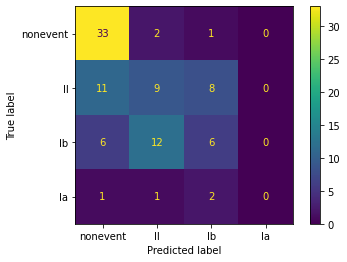

In [154]:
if tpot_enabled:
    print_classification_metrics(y_test, y_pred)